In [155]:
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from pandarallel import pandarallel
from mpl_toolkits import mplot3d as plt3d

In [156]:
telemetry_data_fp = "./Telemetry Data"
# For now, we will only focus on 1 practice session: FP3
df_fp2 = pd.read_csv(telemetry_data_fp + "/T1_Baku_FP2.csv", sep='\t')
df_fp3 = pd.read_csv(telemetry_data_fp + "/T3_Baku_FP3.csv", sep='\t')
df_quali = pd.read_csv(telemetry_data_fp + "/T4_Baku_Qualifying.csv", sep='\t')
df_race = pd.read_csv(telemetry_data_fp + "/T5_Baku_Race.csv", sep='\t')
# Show first 5 rows
df_fp3.head(5)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,...,front_left_wing_damage,front_right_wing_damage,rear_wing_damage,engine_damage,gear_box_damage,ers_store,ers_deployMode,ers_harv_mguk,ers_harv_mguh,ers_deployed
0,Renault,Baku,5994,0,0,0,0,1,0,0.552961,...,0.0,0.0,0,0.7,0.37,3540390.0,2,0.0,181829.0,640634.0
1,Renault,Baku,5994,0,0,0,1,1,0,1.446020,...,0.0,0.0,0,0.7,0.37,3540150.0,2,0.0,145463.0,512507.0
2,Renault,Baku,5994,0,0,0,2,1,0,2.339080,...,0.0,0.0,0,0.7,0.37,3539900.0,2,0.0,109097.0,384380.0
3,Renault,Baku,5994,0,0,0,3,1,0,3.232140,...,0.0,0.0,0,0.7,0.37,3539660.0,2,0.0,72731.6,256254.0
4,Renault,Baku,5994,0,0,0,4,1,0,4.125200,...,0.0,0.0,0,0.7,0.37,3539410.0,2,0.0,36365.8,128127.0


In [157]:
# We want to get the list of data categories
data_categories = list(df_fp3.columns)
# We will reshape our 161 1D list into a 2D list of parameters with 23 groups of 7 (just to make viewing this easier)
print(tabulate(np.array(data_categories).reshape(-1,7), maxcolwidths=8, tablefmt="rounded_grid"))

╭──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────╮
│ carId    │ trackId  │ trackLen │ lapIndex │ lapNum   │ lapFlag  │ binIndex │
│          │          │ gth      │          │          │          │          │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ validBin │ lap_numb │ lap_dist │ lap_time │ lap_time │ world_po │ world_po │
│          │ er       │ ance     │          │ _invalid │ sition_X │ sition_Y │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ world_po │ world_fo │ world_fo │ world_fo │ world_ri │ world_ri │ world_ri │
│ sition_Z │ rward_X  │ rward_Y  │ rward_Z  │ ght_X    │ ght_Y    │ ght_Z    │
├──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ velocity │ velocity │ velocity │ gforce_X │ gforce_Y │ gforce_Z │ pit_stat │
│ _X       │ _Y       │ _Z       │          │          │          │ us       │
├──────────┼──────────┼──────────┼──────────┼───────

Note that these stats can contain invalid laps (caused by track infractions), and so we shouldn't consider these during calculations

In [158]:
# Ensure we are dealing with valid data only
valid_df_fp2 = df_fp2[df_fp2["lap_time_invalid"] > -1]
valid_df_fp3 = df_fp3[df_fp3["lap_time_invalid"] > -1]
valid_df_quali = df_quali[df_quali["lap_time_invalid"] > -1]
valid_df_race = df_race[df_race["lap_time_invalid"] > -1]

# pool = mp.Pool(4) # use 4 processes

# We also need to fix a few off-by-one errors for lap numbers, race position, etc
# This is taking too long to update each df individually since they all have over 30,000 rows
# We can parallelize the updates for each df asynchronously
# pool.apply_async(lambda df: df.update(df[["lapIndex", "lapNum", "lap_number", "race_position"]].apply(lambda x: x + 1, axis=1), overwrite=False),  [valid_df_fp2, valid_df_fp3, valid_df_quali, valid_df_race])
pandarallel.initialize(progress_bar=True, verbose=1)
updated_df_fp2 = valid_df_fp2[["lapIndex", "lapNum", "lap_number", "race_position"]].parallel_apply(lambda x: x + 1, axis=1) # type: ignore
updated_df_fp3 = valid_df_fp3[["lapIndex", "lapNum", "lap_number", "race_position"]].parallel_apply(lambda x: x + 1, axis=1) # type: ignore
updated_df_quali = valid_df_quali[["lapIndex", "lapNum", "lap_number", "race_position"]].parallel_apply(lambda x: x + 1, axis=1) # type: ignore
updated_df_race = valid_df_race[["lapIndex", "lapNum", "lap_number", "race_position"]].parallel_apply(lambda x: x + 1, axis=1) # type: ignore

valid_df_fp2.update(updated_df_fp2)
valid_df_fp3.update(updated_df_fp3)
valid_df_quali.update(updated_df_quali)
valid_df_race.update(updated_df_race)

valid_df_fp3.head(5)



,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,...,front_left_wing_damage,front_right_wing_damage,rear_wing_damage,engine_damage,gear_box_damage,ers_store,ers_deployMode,ers_harv_mguk,ers_harv_mguh,ers_deployed
0,Renault,Baku,5994,1,1,0,0,1,1,0.552961,...,0.0,0.0,0,0.7,0.37,3540390.0,2,0.0,181829.0,640634.0
1,Renault,Baku,5994,1,1,0,1,1,1,1.446020,...,0.0,0.0,0,0.7,0.37,3540150.0,2,0.0,145463.0,512507.0
2,Renault,Baku,5994,1,1,0,2,1,1,2.339080,...,0.0,0.0,0,0.7,0.37,3539900.0,2,0.0,109097.0,384380.0
3,Renault,Baku,5994,1,1,0,3,1,1,3.232140,...,0.0,0.0,0,0.7,0.37,3539660.0,2,0.0,72731.6,256254.0
4,Renault,Baku,5994,1,1,0,4,1,1,4.125200,...,0.0,0.0,0,0.7,0.37,3539410.0,2,0.0,36365.8,128127.0


In [159]:
# Initial Descriptive Analysis

# We use the binIndex to get the completed lap. In high frequency streams of data, 
# we usually divide data into bins, which represent either a segment of time or distance
# this way, we can improve organization and performance by discretizing the continous data

# We will first get the max bin index to figure out how many bins we make (it's around 5994 bins)

max_bin_index = valid_df_fp3["binIndex"].max()
completed_laps_fp2 = valid_df_fp2[valid_df_fp2["binIndex"] == max_bin_index].reset_index(drop=True)
completed_laps_fp3 = valid_df_fp3[valid_df_fp3["binIndex"] == max_bin_index].reset_index(drop=True)
completed_laps_quali = valid_df_quali[valid_df_quali["binIndex"] == max_bin_index].reset_index(drop=True)
completed_laps_race = valid_df_race[valid_df_race["binIndex"] == max_bin_index].reset_index(drop=True)

completed_laps_fp3_pretty_print = completed_laps_race.head(10)
# print(tabulate(completed_laps_fp3_pretty_print, tablefmt="rounded_grid", headers=completed_laps_fp3_pretty_print.columns), end="\n\n")

# Our forward velocity is velocity_X
velocity_description = completed_laps_fp2["velocity_X"].describe()
print(velocity_description, end="\n\n")

# We do have to note here that the these velocities won't be the complete picture since we are looking at 
# the velocity upon lap completion while it may be high since the lap usually completes on a straight, it won't always be the case. 
# For example, here in Baku, we actually achieved a slightly higher velocity elsewhere on the track 
# because we carried forward the speed from our previous flying lap during the 1st lap
# A more accurate velocity analysis would be using valid_df and finding the peak velocity across all points on the track

# More useful summaries for completed laps would be for parameters such as lap time, 
# or parameters that only matter on a lap-by-lap basis
lap_time_description = completed_laps_fp3["lap_time"].describe()
print(lap_time_description, end="\n\n")

# we can sort the lap_times to rank our fastest laps
sorted_laps = completed_laps_fp3.copy()
sorted_laps.sort_values(by="lap_time", inplace=True)
sorted_laps[["lapNum", "lap_time", "race_position"]].reset_index(drop=True)

count     5.00000
mean     75.25006
std      30.02878
min      21.60190
25%      86.83200
50%      87.48600
75%      90.12630
max      90.20410
Name: velocity_X, dtype: float64

count      8.00000
mean     113.02825
std        2.21416
min      109.50500
25%      111.38925
50%      113.74300
75%      114.65000
max      115.61800
Name: lap_time, dtype: float64



,lapNum,lap_time,race_position
0,2,109.505,1
1,1,110.487,6
2,3,111.690,1
3,6,113.457,1
4,8,114.029,1
5,7,114.580,1
6,5,114.860,1
7,4,115.618,1


In [160]:
# Lap times are also influenced by tire compounds, we can actually group the sorted times based on tire compounds and output them
# Although, rather than outputting the tire compound number, it's best to translate it to the corresponding compound name
# See the F1 2019 Spec sheet in the README for specific translations

actual_tyre_compound_map = {
    "16": "C5", # Softest tyre compound
    "17": "C4",
    "18": "C3",
    "19": "C2",
    "20": "C1", # Hardest tyre compound
    "7": "Intermediate",
    "8": "Wet"
}

wet_tyre_compounds = [7, 8]

# We need to actually figure out what the Soft, Medium, and Hard compounds are for the weekend
# since 3/5 of the dry compounds are used for the track depending on how abrasive the track is
# and if there are high temperatures
# We will get the Soft compound from Quali to then map to the compound map
# If the tyres are not dry tires, we will need to find the unique set from FP1 - FP3
# Later on, when I make my own Telemetry Interpreter, I'll include both the actual and visual compound parameters
# so I don't have to do this guess work (since it is possible for the race weekend to be completely wet)
quali_compound = valid_df_quali["tyre_compound_0"].unique().min()
print(quali_compound)

actual_soft_compound = quali_compound

if quali_compound in wet_tyre_compounds:
    # if we had FP1, we'd include it too
    unique_fp_compounds = [*df_fp2["tyre_compound_0"].unique(), 
                           *df_fp3["tyre_compound_0"].unique()]
    unique_dry_compounds = list(filter(lambda compound: compound not in wet_tyre_compounds, unique_fp_compounds))
    if len(unique_dry_compounds) != 0:
        actual_soft_compound = min(unique_dry_compounds)

visual_tyre_compound_map = {
    actual_soft_compound: "Soft",
    actual_soft_compound + 1: "Medium",
    actual_soft_compound + 2: "Hard",
    "7": "Intermediate",
    "8": "Wet"
}

sorted_laps.sort_values(by=["tyre_compound_0", "lap_time"], inplace=True)
visual_compound_sorted_laps = sorted_laps.copy()
visual_compound_sorted_laps["tyre_compound_0"] = visual_compound_sorted_laps["tyre_compound_0"].map(lambda c: visual_tyre_compound_map.get(c, c))
visual_compound_sorted_laps[["lapNum", "lap_time", "race_position", "tyre_compound_0"]].reset_index(drop=True)

17


,lapNum,lap_time,race_position,tyre_compound_0
0,2,109.505,1,Soft
1,1,110.487,6,Soft
2,3,111.690,1,Medium
3,6,113.457,1,Medium
4,8,114.029,1,Medium
5,7,114.580,1,Medium
6,5,114.860,1,Medium
7,4,115.618,1,Medium


In [161]:
# Velocity (considering all points along the track)
# Mean velocity in m/s
def mps_to_kph(v):
    return v * 3.6
def kph_to_mps(v): 
    return v / 3.6

mean_velocity_3D = valid_df_fp3.aggregate({"velocity_X": "mean", "velocity_Y": "mean", "velocity_Z": "mean"})
print(f"Mean velocities 3D (mps):\n{mean_velocity_3D.to_string()
    } \n\nMean velocities 3D (kph):\n{
    mean_velocity_3D.map(lambda x: f"{round(mps_to_kph(x), ndigits=1)} km/h")
}", end='\n')

# Peak Velocity (we also want to know when we reached this (so likely which sector of the lap and also use lap distance))
# We can later use this information to represent a visual on a track map to show where these peaks were reached, and other useful information
# We will consider velocity_X only here since we want to have the forward line speed
peak_forward_velocity_mps = valid_df_fp3.aggregate({"velocity_X": "max"})
peak_forward_velocity = peak_forward_velocity_mps.map(mps_to_kph)

peak_forward_velocity_data = pd.DataFrame(valid_df_fp3.loc[valid_df_fp3['velocity_X'] == peak_forward_velocity_mps.item()])
peak_forward_velocity_sector = int(peak_forward_velocity_data["lap_distance"].item() // peak_forward_velocity_data["trackLength"].item())
peak_forward_velcity_world_pos = peak_forward_velocity_data[["world_position_X", "world_position_Y", "world_position_Z"]]

print(f"\nPeak forward velocity: {round(peak_forward_velocity.item(), ndigits=1)} km/h")
print(f"Peak forward velocity: {peak_forward_velocity_mps.item()} mps")


Mean velocities 3D (mps):
velocity_X    60.966483
velocity_Y     0.044903
velocity_Z     0.051058 

Mean velocities 3D (kph):
velocity_X    219.5 km/h
velocity_Y      0.2 km/h
velocity_Z      0.2 km/h
dtype: object

Peak forward velocity: 325.3 km/h
Peak forward velocity: 90.3725 mps


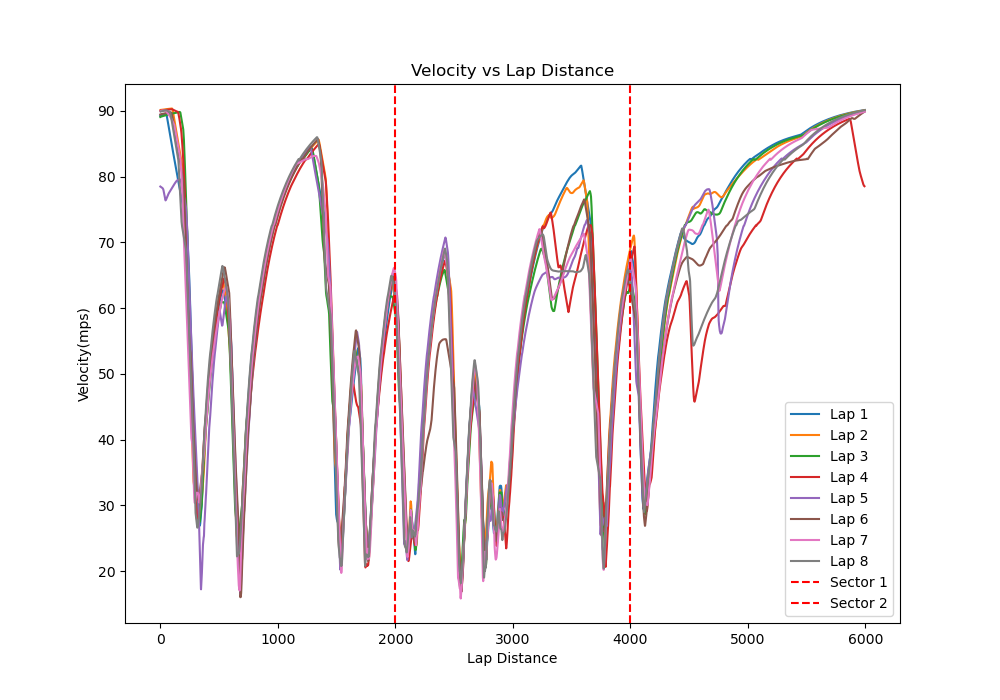

In [162]:
data_per_lap = []
for _, g in valid_df_fp3.groupby("lapNum"):
    data_per_lap.append(g)

ax = data_per_lap[0].plot(x="lap_distance", y="velocity_X", title="Velocity vs Lap Distance", label="Lap 1", xlabel="Lap Distance", ylabel=f"Velocity(mps)", figsize=(10,7))
for lap_num, lap in enumerate(data_per_lap[1::]):
    lap.plot(x="lap_distance", y="velocity_X", title="Velocity vs Lap Distance", xlabel="Lap Distance", ylabel=f"Velocity(mps)", label=f"Lap {lap_num + 2}", figsize=(10,7), ax=ax)
plt.axvline(x=max_bin_index/3, color="r", linestyle="--", label="Sector 1")
plt.axvline(x=max_bin_index/3 * 2, color="r", linestyle="--", label="Sector 2")
plt.legend()
plt.show()

#### We can see that our lap tends to be fairly clean in Sector 1, but near the middle of Sector 2 and all of Sector 3, our velocity becomes erratic! Let's see if we can uncover what's going on based on our throttle, braking, and tyre wear, and lap_time (throughout the lap), and location on track

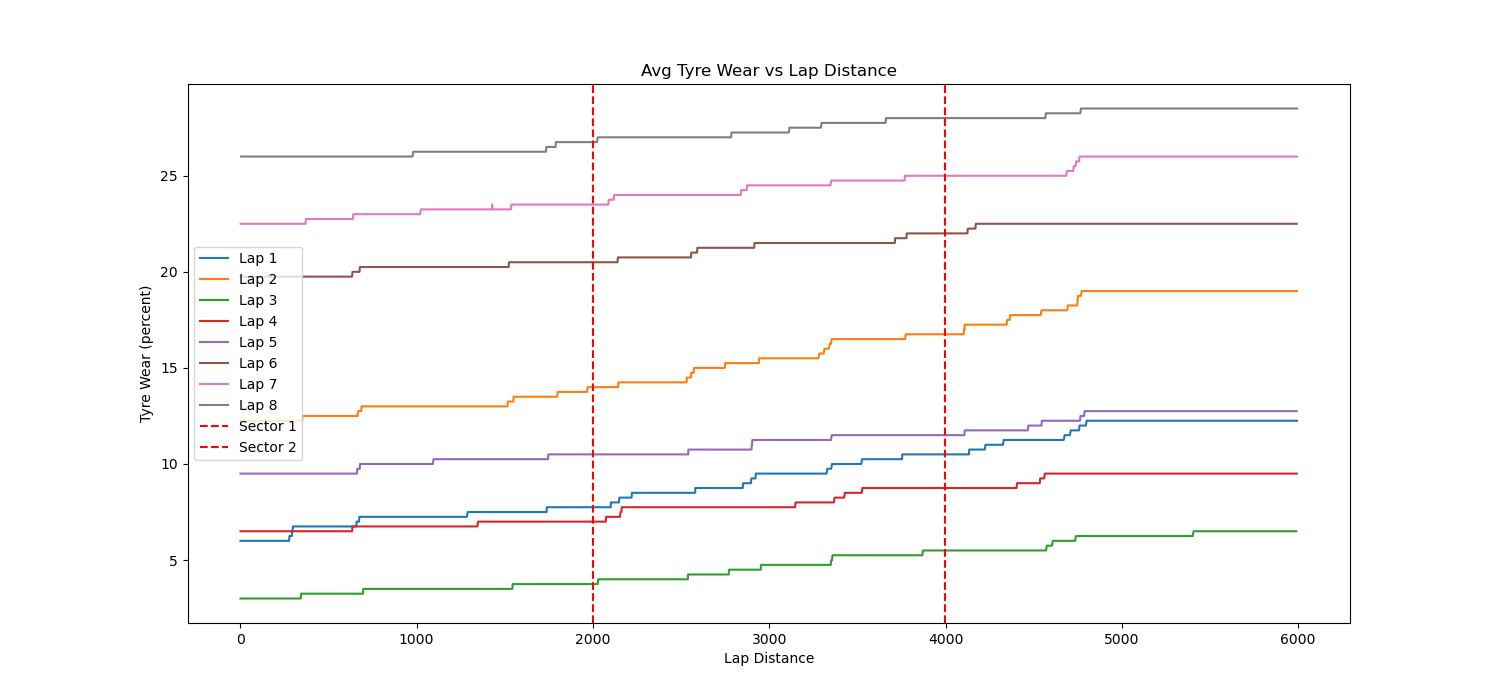

In [163]:
# Let's take a look at how our tyre wear changes per lap

# Plotting 4 tyre wear lines (one for each wheel) for 8 laps will be too many lines to plot
# So let's average the tyre wear across all wheels and then plot it lap-by-lap (but )

tyre_wear_per_lap = []

for lap_df in data_per_lap:
    tyre_wear_df = lap_df.copy()
    tyre_wear_df["avg_tyre_wear"] = tyre_wear_df[["tyre_wear_0", "tyre_wear_1", "tyre_wear_2", "tyre_wear_3",]].mean(axis=1)
    tyre_wear_df["avg_tyre_wear"] = tyre_wear_df["avg_tyre_wear"].transform(lambda x: x * 100)
    tyre_wear_per_lap.append(tyre_wear_df)

ax = tyre_wear_per_lap[0].plot(x="lap_distance", 
                        #   y=["tyre_wear_0", "tyre_wear_1", "tyre_wear_2", "tyre_wear_3"], 
                          y = "avg_tyre_wear",
                          title="Avg Tyre Wear vs Lap Distance", 
                          label = "Lap 1",
                        #   label=["Lap 1 Tyre Wear FR", "Lap 1 Tyre Wear FL", "Lap 1 Tyre Wear RR", "Lap 1 Tyre Wear RL"], 
                          xlabel="Lap Distance", ylabel=f"Tyre Wear (percent)", figsize=(10,7))
for lap_num, lap in enumerate(tyre_wear_per_lap[1::]):
    lap.plot(x="lap_distance", 
            #  y=["tyre_wear_0", "tyre_wear_1", "tyre_wear_2", "tyre_wear_3"], 
             y = "avg_tyre_wear",
             title="Avg Tyre Wear vs Lap Distance", 
            #  label=[f"Lap {lap_num} Tyre Wear FR", f"Lap {lap_num} Tyre Wear FL", f"Lap {lap_num} Tyre Wear RR", f"Lap {lap_num} Tyre Wear RL"], 
             label=f"Lap {lap_num + 2}",
             xlabel="Lap Distance", ylabel=f"Tyre Wear (percent)", figsize=(15,7), ax=ax)
plt.axvline(x=max_bin_index/3, color="r", linestyle="--", label="Sector 1")
plt.axvline(x=max_bin_index/3 * 2, color="r", linestyle="--", label="Sector 2")
plt.legend()
plt.show()
    

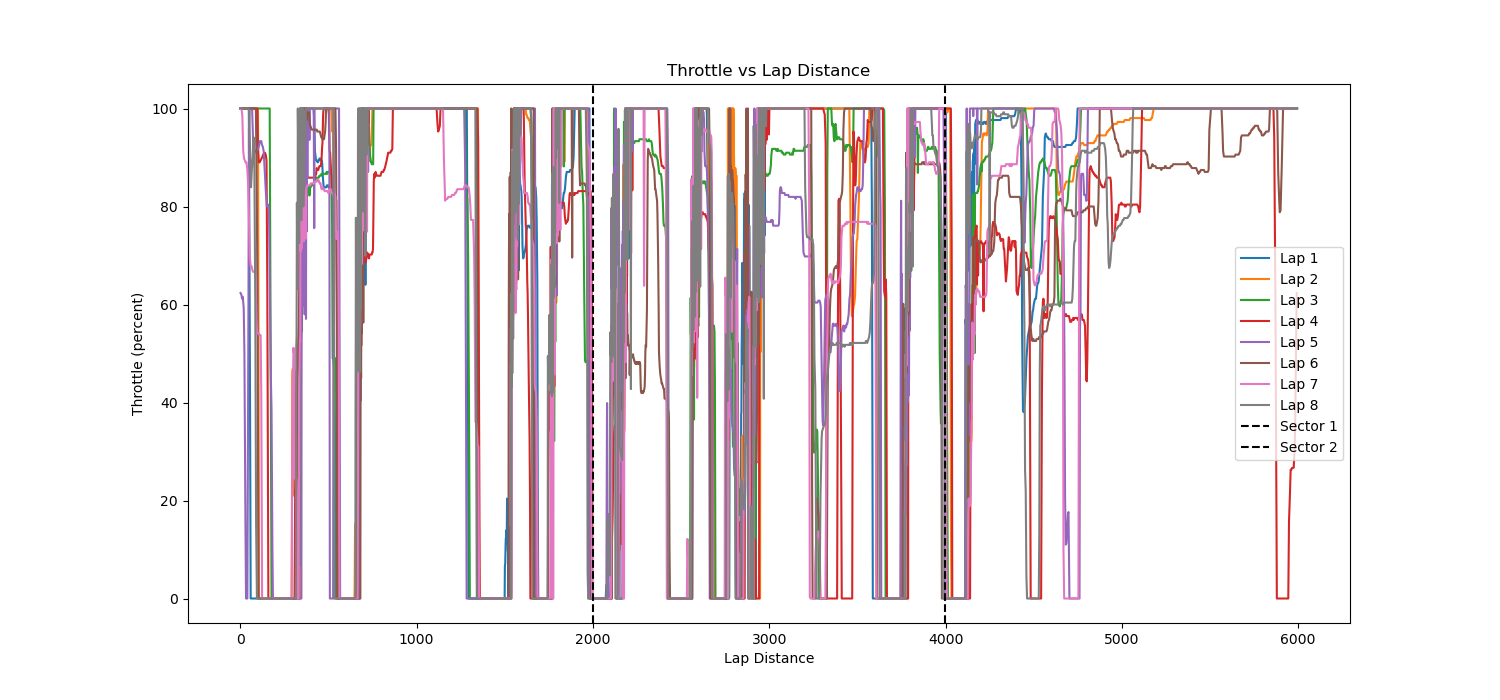

In [164]:
# Let's take a look at the throttle and braking graphs
# It's actually better to combine both throttle and braking into a single graph so 
# we get the full picture for acceleration and deceleration 
# First though, we'll take a look at the throttle only, over each lap
# then we can focus on on throttle vs braking on a single lap


throttle_per_lap = data_per_lap.copy()

for lap_df in throttle_per_lap:
    lap_df["throttle"] = lap_df["throttle"].transform(lambda x: x * 100 if x <= 1.0 else x)

ax = throttle_per_lap[0].plot(x="lap_distance", 
                          # y = ["throttle", "brake"],
                          y="throttle",
                          title="Throttle vs Lap Distance", 
                          # label = ["Lap 1 Throttle", "Lap 1 Brake"],
                          label="Lap 1",
                          xlabel="Lap Distance", ylabel=f"Throttle (percent)", figsize=(15,7))

for lap_num, lap_data in enumerate(throttle_per_lap[1::]):
    lap_data.plot(x="lap_distance", 
                          # y = ["throttle", "brake"],
                          y = "throttle",
                          title="Throttle vs Lap Distance", 
                          # label = [f"Lap {lap_num} Throttle", f"Lap {lap_num} Brake"],
                          label=f"Lap {lap_num + 2}",
                          xlabel="Lap Distance", ylabel=f"Throttle (percent)", figsize=(15,7), ax=ax)
plt.axvline(x=max_bin_index/3, color="black", linestyle="--", label="Sector 1")
plt.axvline(x=max_bin_index/3 * 2, color="black", linestyle="--", label="Sector 2")
plt.legend()
plt.show()

#### This is already looking very chaotic in the 3rd sector. This might actually be a better factor for the velocity discrepancies above rather than tyre wear.
#### Actually, the throttle variations here tend to show that I'm making a lot of minute adjustments and I'm not committing to a particular racing line. I have a hunch this might correspond to the castle section in Baku, and it might be costing me time since the s-bend turn is very narrow and prone to crashing.

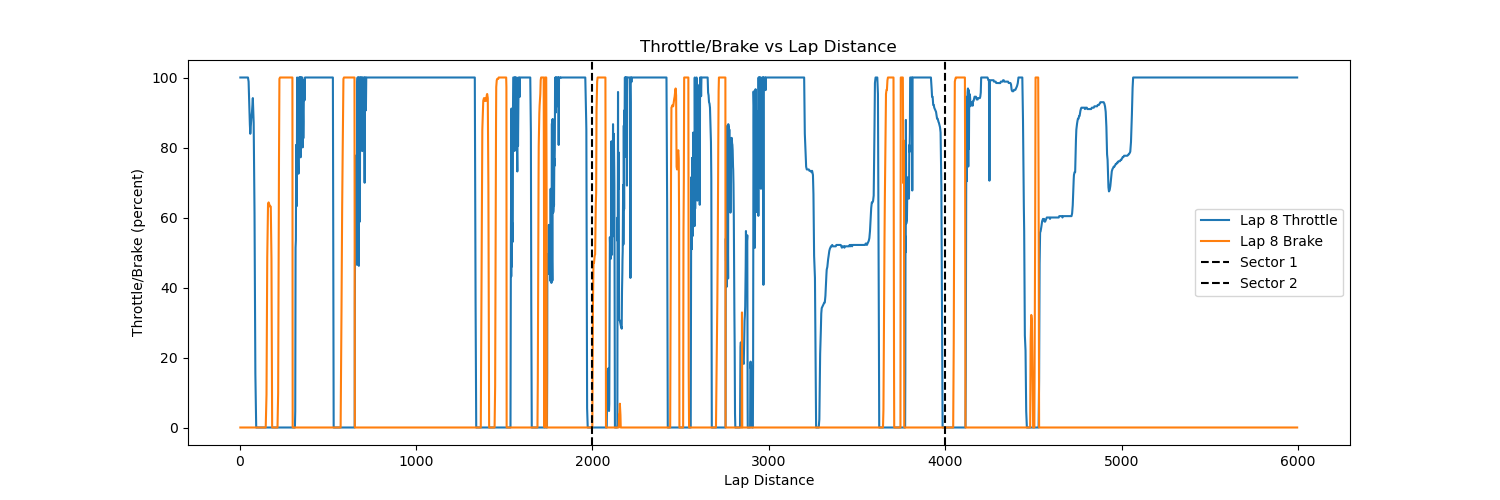

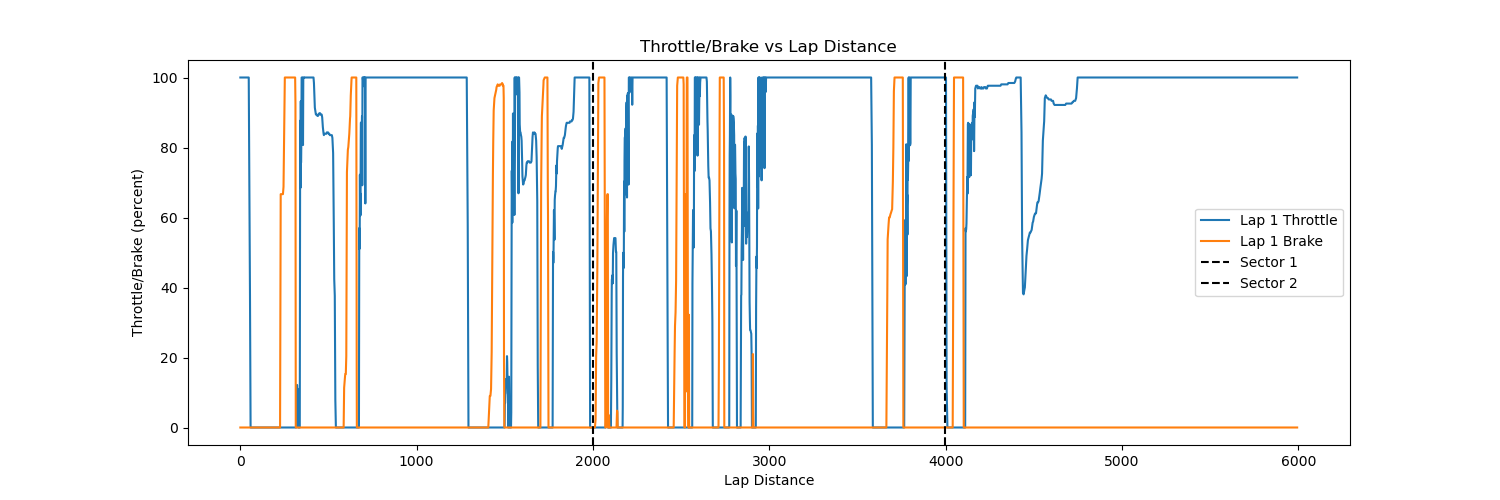

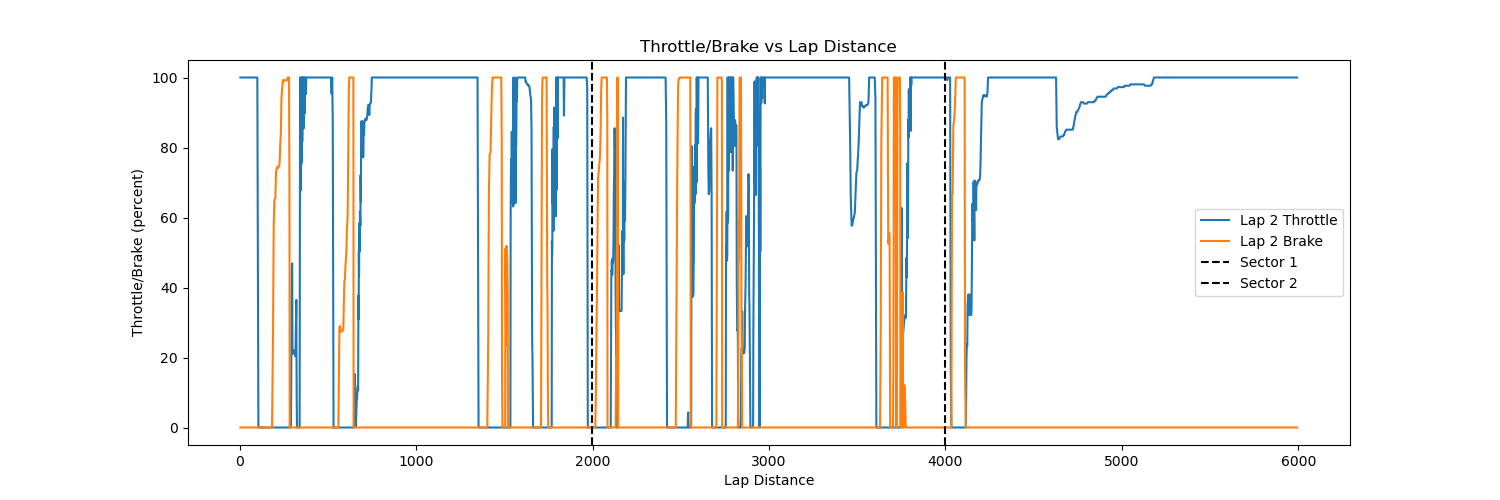

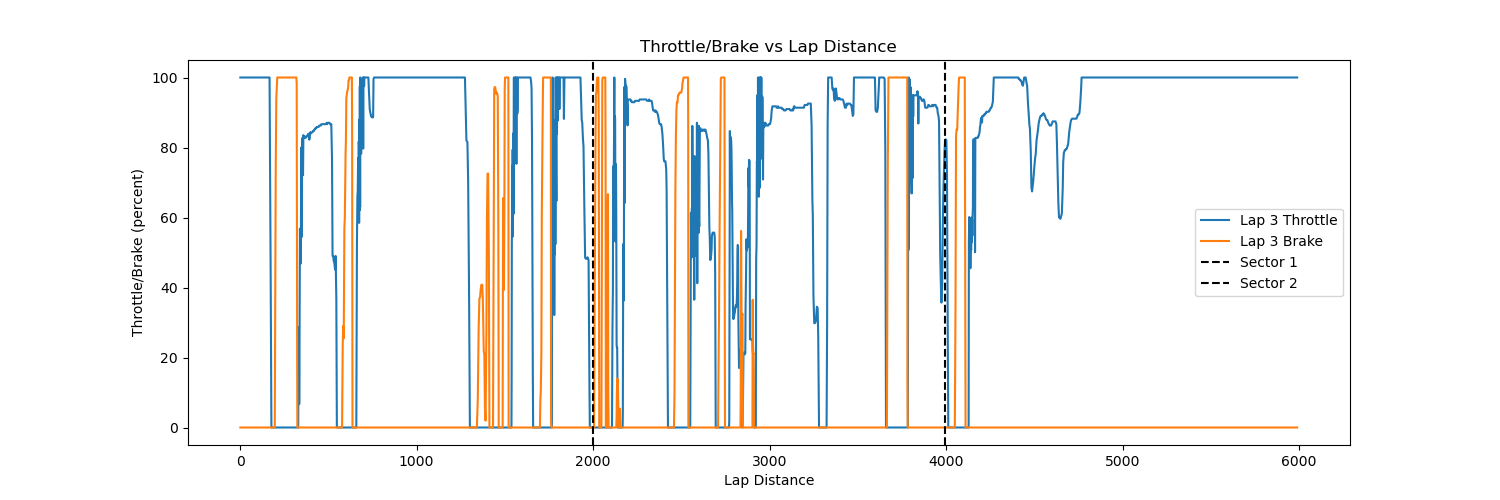

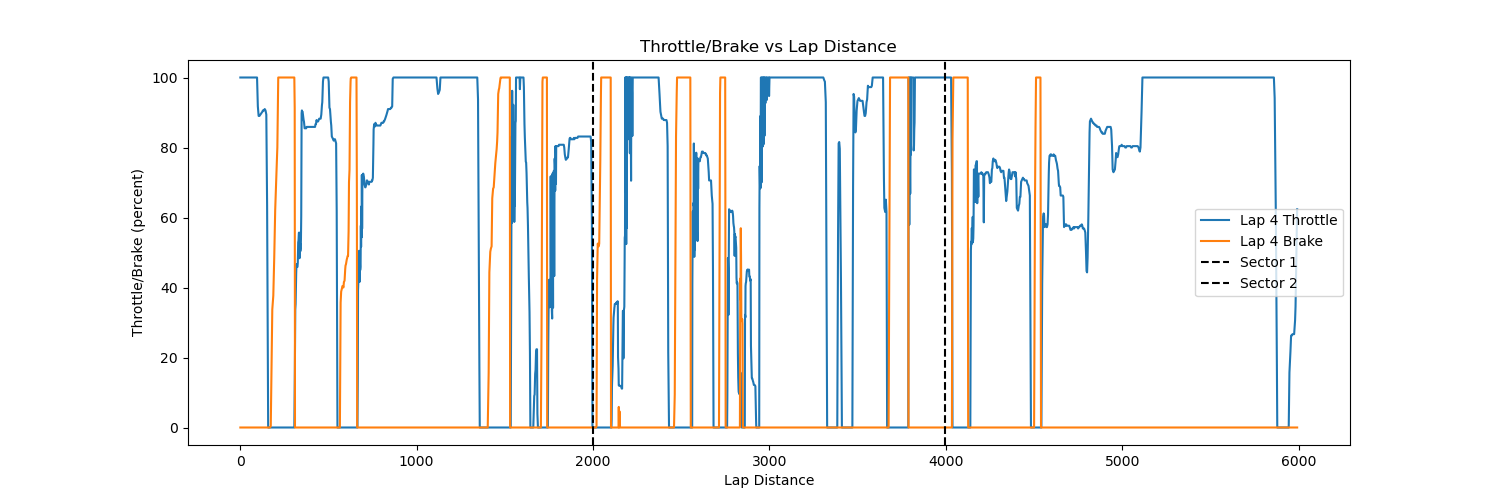

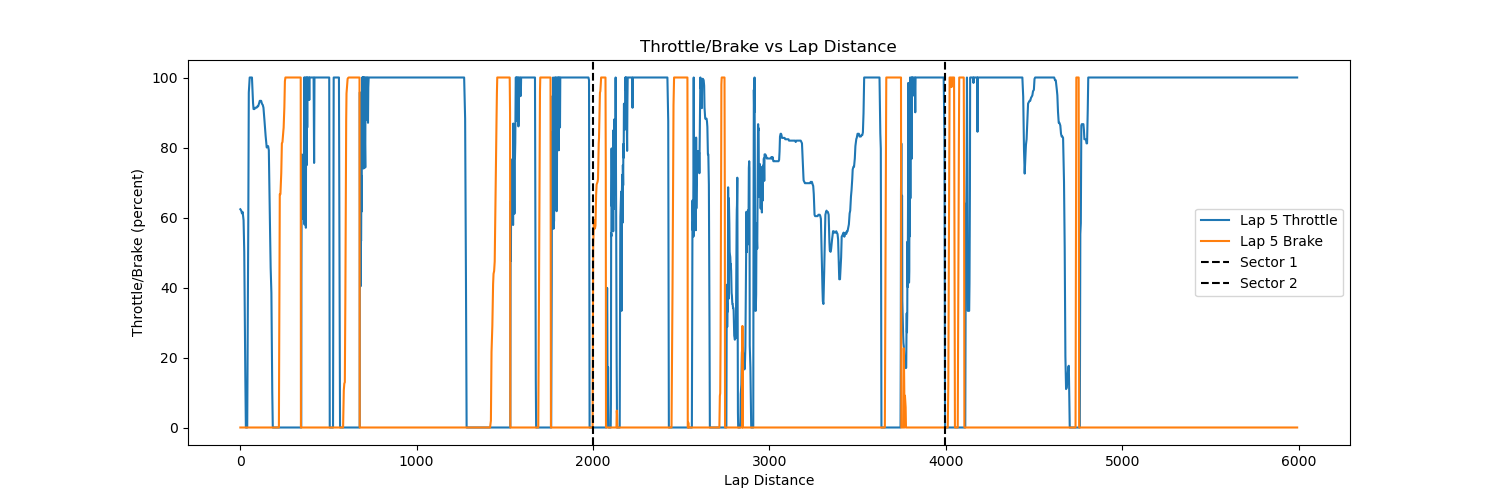

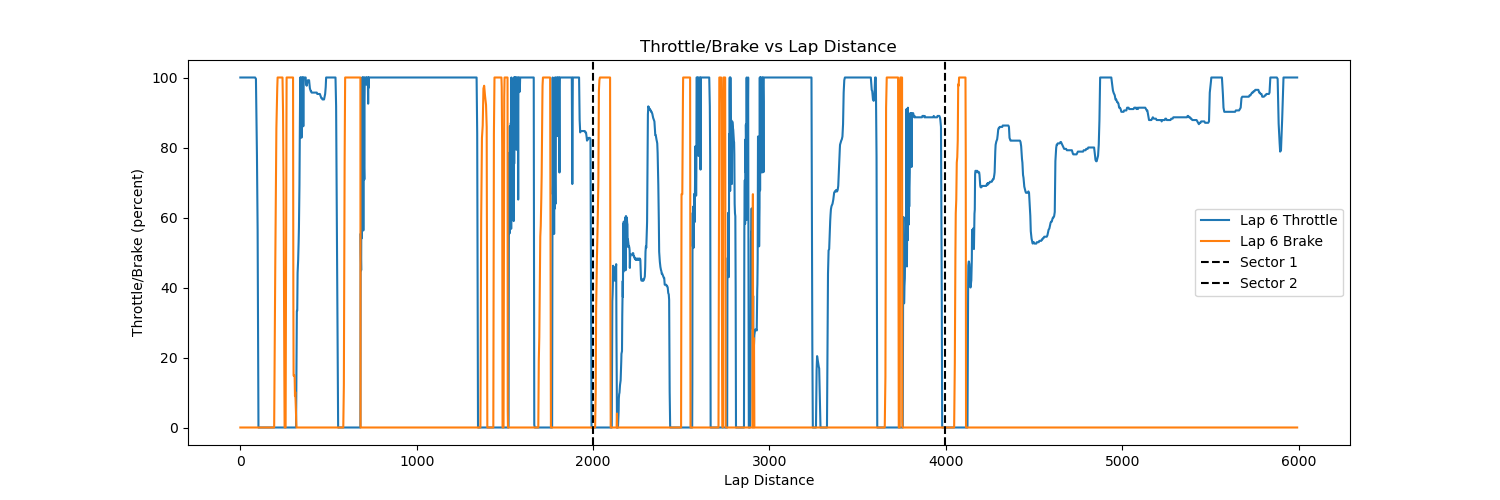

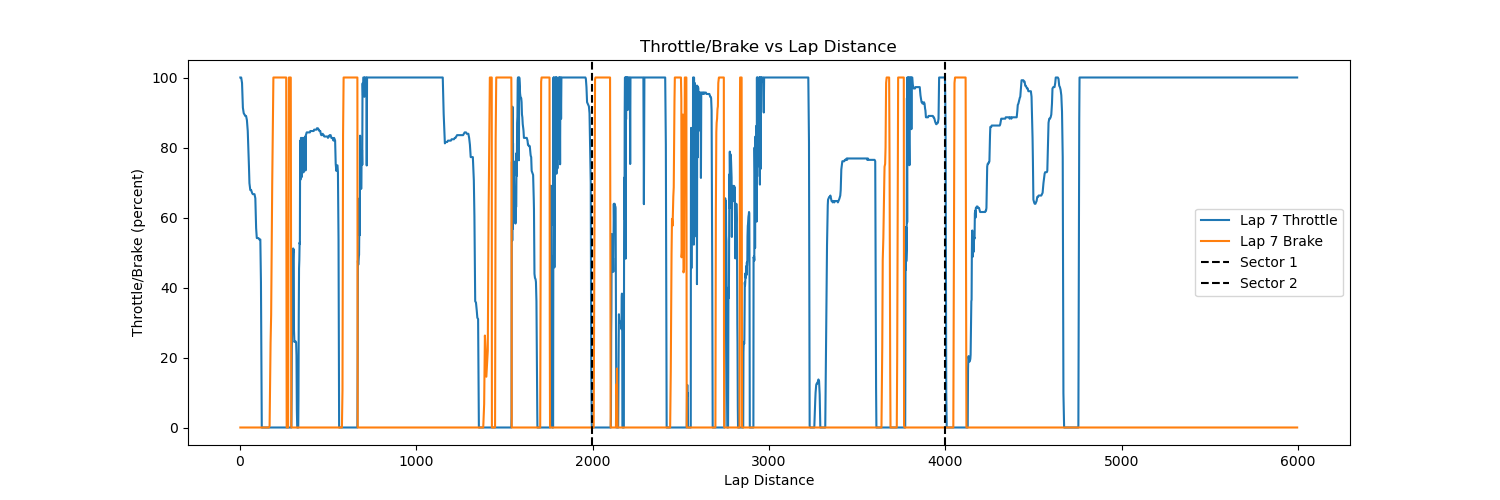

In [165]:

throttle_brake_per_lap = throttle_per_lap.copy()


for lap_df in throttle_brake_per_lap:
    lap_df["brake"] = lap_df["brake"].transform(lambda x: x * 100 if x <= 1.0 else x)

for lap_num, lap_data in enumerate(throttle_brake_per_lap):
    lap_data.plot(x="lap_distance", 
                          y = ["throttle", "brake"],
                          title="Throttle/Brake vs Lap Distance", 
                          label = [f"Lap {lap_num + 1} Throttle", f"Lap {lap_num + 1} Brake"],
                          xlabel="Lap Distance", ylabel=f"Throttle/Brake (percent)", figsize=(15,5))
    plt.axvline(x=max_bin_index/3, color="black", linestyle="--", label="Sector 1")
    plt.axvline(x=max_bin_index/3 * 2, color="black", linestyle="--", label="Sector 2")
    plt.legend()
plt.show()

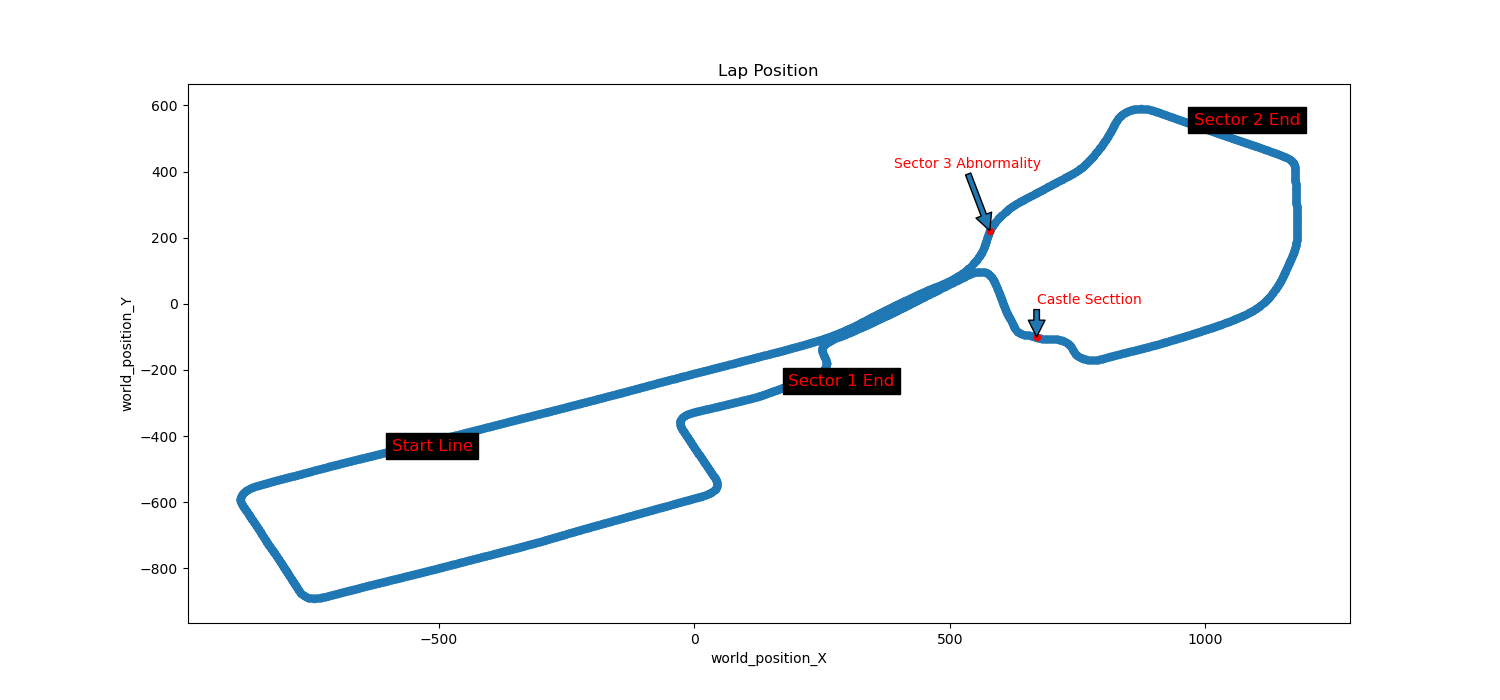

In [166]:
# 1 Lap Map

from matplotlib.pylab import annotate, xlabel, ylabel

world_pos_df = valid_df_fp3.loc[valid_df_fp3["lapNum"] == 1][["world_position_X", "world_position_Y", "world_position_Z"]]

start_line_coords = world_pos_df.head(1)[["world_position_X", "world_position_Y"]].to_numpy()[0] # This is also where sector 3 ends and sector 1 starts
sector_1_end_coords = valid_df_fp3.loc[valid_df_fp3["binIndex"] == max_bin_index//3][["world_position_X", "world_position_Y"]].to_numpy()[0]
sector_2_end_coords = valid_df_fp3.loc[valid_df_fp3["binIndex"] == max_bin_index//3 * 2][["world_position_X", "world_position_Y"]].to_numpy()[0]
castle_section_coords = pd.DataFrame({"world_position_X": [670], "world_position_Y": [-100]})
castle_section_annot_coords = pd.DataFrame({"world_position_X": [670], "world_position_Y": [0]})

plot = world_pos_df[["world_position_X", "world_position_Y"]].plot.scatter(x="world_position_X", y="world_position_Y", 
                                                                    title="Lap Position", xlabel="World Position X", ylabel="World Position Y", figsize=(15,7))
castle_section_coords.plot.scatter(x="world_position_X", y="world_position_Y", ax=plot, color="red")
plot.annotate("Start Line", xy=start_line_coords, fontsize="large", color="red", backgroundcolor="black")
plot.annotate("Sector 1 End", xy=sector_1_end_coords, fontsize="large", color="red", backgroundcolor="black")
plot.annotate("Sector 2 End", xy=sector_2_end_coords, fontsize="large", color="red", backgroundcolor="black")
plot.annotate("Castle Secttion", xy=castle_section_coords.to_numpy()[0], xytext=castle_section_annot_coords.to_numpy()[0], fontsize="medium", color="red", arrowprops={})

sector_3_abnormality_bin = 4600

sector_3_abnormality_df = valid_df_fp3.loc[(valid_df_fp3["binIndex"] == sector_3_abnormality_bin) & (valid_df_fp3["lapNum"] == 1)][["world_position_X", "world_position_Y"]]
sector_3_abnormality_pos = [390, 410]
sector_3_abnormality_df.plot.scatter(x="world_position_X", y="world_position_Y", ax=plot, color="red")
plot.annotate("Sector 3 Abnormality", xy= sector_3_abnormality_df.to_numpy()[0], xytext=sector_3_abnormality_pos, fontsize="medium", color="red", arrowprops={})
plt.show()

##### This explains the abnormalities in Sector 2 since the castle section is in sector 2

In [167]:
# # Matplotlib eating up too much memory, so let's close the figures before we continue
# plt.close("all")

